# MODELAGEM POR TÓPICOS - DADOS DA ANVISA

## Importando o BD & Inicializando variáveis

In [5]:
!pip install pyLDAvis
import pandas as pd
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=abd28f27e446be4d9b31e47cb6d42b3ecfdf45fb380538af5f31206f5d179acf
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=421b7c59e7319a215f74d713d897773714f95def246d7c68d09aa535bc269ea9
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [ ]:
## opcao de leitura do arquivo direto do nosso diretorio compartilhado no gdrive ##
from google.colab import drive
drive.mount('/content/drive/')
path_drive = '/content/drive/My Drive/IC - Matheus/'
path_datasets = path_drive + 'Datasets/'
path_models = path_drive + 'Códigos/Modelos/'
ENTITY = 'ANVISA'

Mounted at /content/drive/


In [ ]:
# número de tópicos escolhido
num_topics = 20

In [ ]:
## arquivos que serão gerados / lidos
LDAvis_data_filepath = os.path.join(path_models + ENTITY + '_ldavis_prepared_'+str(num_topics))
LDAvis_html_filepath = os.path.join(LDAvis_data_filepath + '.html')
lda_model_filepath = os.path.join(path_models + ENTITY + '_lda_model_' + str(num_topics))
corpus_filepath = os.path.join(path_models + ENTITY + '_corpus_' + str(num_topics))
id2word_filepath = os.path.join(path_models + ENTITY + '_id2word_' + str(num_topics))

keys_unicas = os.path.join(path_models + ENTITY + '_Keys_unicas_' + str(num_topics) + '.xlsx')
keys_todas = os.path.join(path_models + ENTITY + '_Keys_Todas_' + str(num_topics) + '.xlsx')

covid_dataset_final = os.path.join(path_models + ENTITY + '_coviddatasetfinal_' + str(num_topics) + '.csv')

In [ ]:
df = pd.read_csv(path_datasets + "dataset_anvisa.csv", encoding='utf8')

In [ ]:
covid = df
covid.head()

,Unnamed: 0,title,created,link,summary,full_created,full_content
0,0,Anvisa alerta sobre instabilidade no sistema S...,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/notic...,Sistema apresenta lentidão no processamento e ...,09/11/2021 14h50,\nA Anvisa informa que o Sistema Nacional de G...
1,1,Embarque em cruzeiros exige vacinação completa...,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/notic...,Vai viajar em navio de cruzeiro? Veja o que vo...,09/11/2021 12h32,\nPelo menos 25 passageiros de navios de cruze...
2,2,Confira os resultados do monitoramento de dese...,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/notic...,Documento traz dados sobre o alcance e o cumpr...,09/11/2021 12h11,\nJá está disponível para consulta o Relatório...
3,3,Acompanhe a reunião da Dicol desta quarta-feira,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/notic...,Diretores se reúnem a partir das 9h30. Acompan...,09/11/2021 11h12,\n22ª Reunião Ordinária Pública da Diretoria C...
4,4,Anvisa alerta sobre tentativa de fraude por e-...,08/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/notic...,Usuários relataram o recebimento de e-mails de...,08/11/2021 12h18,\nA Anvisa alerta ter recebido reclamações de ...


## Pré-processamento dos dados

In [ ]:
import os
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Acrescentarei manualmente a palavra "sobre" às stop words, pois não é relevante e estava ocorrendo muito

list_stop_words = ['sobre', 'ser', 'anvisa', 'agência', 'brasil', 'agencia', 'sanitaria', 'vigilancia']

stop_words.update(list_stop_words)

In [ ]:
#Criaremos a função para pré processamento dos dados

def preprocess(raw_text):
    
    #Expressão regular para manter apenas letras no texto 
    letters_only_text = re.sub("[^a-zA-ZãõÃÕçÇáéíóúÁÉÍÓÚâêîôûÂÊÎÔÛ]", " ", raw_text) #DUVIDA: COMO RESUMIR ESSE CÓDIGO? OU FIZ CERTO? COMO REMOVER O \n TAMBÉM

    #Converter o texto todo para minúsculo e fazer um split -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()

    cleaned_words = []
    
    #remover stopwords
    for word in words:
      if word not in stop_words:
        cleaned_words.append(word)
    
    #transformar a lista em uma string novamente
    return " ".join(cleaned_words)

In [ ]:
#Substitui os vazios da coluna full_content pelo texto do summary (onde tinha summary)

for i in range(0,len(covid)):
  if (pd.isnull(covid['full_content'][i])):
    covid['full_content'][i] = covid['summary'][i]

covid = covid[covid['full_content'].notnull()]
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 0 to 1130
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1129 non-null   int64 
 1   title         1129 non-null   object
 2   created       1129 non-null   object
 3   link          1129 non-null   object
 4   summary       1116 non-null   object
 5   full_created  1129 non-null   object
 6   full_content  1129 non-null   object
dtypes: int64(1), object(6)
memory usage: 70.6+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
covid['prep'] = covid['full_content'].apply(preprocess) #cria uma nova coluna 'prep' que trará os dados pré processados, removendo pontos e stop words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
covid.iloc[0,7]

'informa sistema nacional gerenciamento produtos controlados sngpc passando períodos instabilidade desde última sexta feira outubro instabilidade culmina lentidão utilização funcionalidades sistema acarreta erros acesso gera demora processamento validação arquivos xml gerência geral monitoramento produtos sujeitos vigilância sanitária ggmon gerência geral tecnologia informação ggtin empenhadas solucionar instabilidade regularizar acesso utilização envio arquivos xml meio sistema conforme artigo resolução diretoria colegiada rdc deverá objeto autuação falta regularidade transmissão movimentações emissão relatórios motivo estritamente instabilidade operacional próprio sngpc dessa forma falta envio arquivos xml período momento comprovadamente ocorrido devido dificuldade acesso sistema estará amparada resolução citada'

In [ ]:
covid.iloc[0,6]

'\nA Anvisa informa que o Sistema Nacional de Gerenciamento de Produtos Controlados (SNGPC) está passando por períodos de instabilidade desde a última sexta-feira, 5 de outubro.\nA instabilidade culmina em lentidão para utilização das funcionalidades do sistema, acarreta erros de acesso e gera demora no processamento e na validação de arquivos XML.\nA Gerência-Geral de Monitoramento de Produtos Sujeitos à Vigilância Sanitária (GGMON) e a Gerência-Geral de Tecnologia da Informação (GGTIN) estão empenhadas em solucionar a instabilidade e regularizar o acesso, a utilização e o envio de arquivos XML por meio do sistema.\nConforme o artigo 33 da Resolução da Diretoria Colegiada (RDC) 22/2014, “Não deverá ser objeto de autuação a falta de regularidade na transmissão das movimentações e emissão de relatórios quando o motivo for estritamente instabilidade operacional do próprio SNGPC.”\nDessa forma, a falta de envio de arquivos XML no período de 5/10 até o momento, que comprovadamente tenha oc

## **Processo para criação dos tópicos**

**======= INIT: Do not run the following cells =======**

In [ ]:
#Convertendo o objeto tokenizado em um corpus e dicionário

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = covid.prep.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['informa', 'sistema', 'nacional', 'gerenciamento', 'produtos', 'controlados', 'sngpc', 'passando', 'periodos', 'instabilidade', 'desde', 'ultima', 'sexta', 'feira', 'outubro', 'instabilidade', 'culmina', 'lentidao', 'utilizacao', 'funcionalidades', 'sistema', 'acarreta', 'erros', 'acesso', 'gera', 'demora', 'processamento', 'validacao', 'arquivos', 'xml']


In [ ]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Trigrams
data_words = make_trigrams(data_words)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
import gensim.corpora as corpora

#Criando um dicionário
id2word = corpora.Dictionary(data_words)

# filter by frequency
id2word.filter_extremes(no_below=5, no_above=0.95)

#Criando um "corpus"
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 3), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 4), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
dict(id2word) #Dicionário atribuindo um número a cada token

{0: 'acesso',
 1: 'arquivos',
 2: 'artigo',
 3: 'conforme',
 4: 'controlados',
 5: 'desde',
 6: 'dessa',
 7: 'devera',
 8: 'devido',
 9: 'dificuldade',
 10: 'emissao',
 11: 'envio',
 12: 'erros',
 13: 'estara',
 14: 'falta',
 15: 'forma',
 16: 'gerencia_geral',
 17: 'gerencia_geral_tecnologia',
 18: 'gerenciamento',
 19: 'informa',
 20: 'informacao_ggtin',
 21: 'instabilidade',
 22: 'meio',
 23: 'momento',
 24: 'monitoramento',
 25: 'motivo',
 26: 'nacional',
 27: 'objeto',
 28: 'ocorrido',
 29: 'operacional',
 30: 'outubro',
 31: 'passando',
 32: 'periodo',
 33: 'periodos',
 34: 'processamento',
 35: 'produtos',
 36: 'proprio',
 37: 'rdc',
 38: 'regularidade',
 39: 'relatorios',
 40: 'resolucao',
 41: 'resolucao_diretoria_colegiada',
 42: 'sistema',
 43: 'sngpc',
 44: 'solucionar',
 45: 'sujeitos_vigilancia_sanitaria_ggmon',
 46: 'transmissao',
 47: 'ultima_sexta_feira',
 48: 'utilizacao',
 49: 'validacao',
 50: 'alcance',
 51: 'antes',
 52: 'antes_embarque',
 53: 'antigeno',
 54: 'ap

### Valor da Coerência

O valor de coerência mede, dentro de um único tópico, a coerência semântica das palavras dentro dele, utilizando a métrica de cossenos para sua similaridade, que vai de 0 a 1. Este é um dos modelos de coerência (o c_v), existem outros, que não cabem a discussão neste post. Existem outros critérios para avaliar também modelagem de tópicos, como a perplexidade.

100%|██████████| 5/5 [00:43<00:00,  8.61s/it]


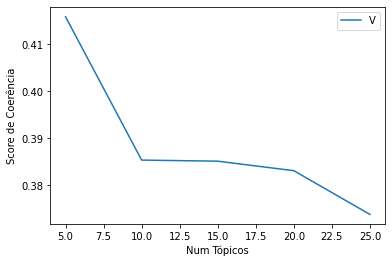

A quantidade de tópicos = 5  tem um valor de coerência de  0.4159
A quantidade de tópicos = 10  tem um valor de coerência de  0.3854
A quantidade de tópicos = 15  tem um valor de coerência de  0.3851
A quantidade de tópicos = 20  tem um valor de coerência de  0.3831
A quantidade de tópicos = 25  tem um valor de coerência de  0.3738


In [ ]:
from tqdm import tqdm
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Função para determinar a melhor quantidade de tópicos para a modelagem
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        #model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=200,
                                       random_state=500
                                       )
        model = lda_model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
limit=30; start=5; step=5;
# Colocando parametros na função
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Mostrando visualmente a quantidade de tópicos
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

### Gerando o modelo final de tópicos

In [ ]:
from pprint import pprint

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=200,
                                       random_state=500
                                       )
# Print top-n keywords of each topic
pprint(lda_model.print_topics(num_words=20))
doc_lda = lda_model[corpus]

[(0,
  '0.009*"analise" + 0.008*"vacinas" + 0.008*"informacoes" + 0.007*"dados" + '
  '0.007*"monitoramento" + 0.007*"vacina" + 0.007*"uso" + 0.007*"covid" + '
  '0.006*"medicamentos" + 0.006*"registro" + 0.005*"emergencial" + '
  '0.005*"autorizacao" + 0.005*"rdc" + 0.005*"empresa" + 0.004*"processo" + '
  '0.004*"dia" + 0.004*"apos" + 0.004*"saude" + 0.004*"produtos" + '
  '0.004*"durante"'),
 (1,
  '0.014*"saude" + 0.008*"seguranca" + 0.007*"sistema" + 0.006*"medicamentos" '
  '+ 0.006*"produtos" + 0.006*"dia" + 0.006*"servicos" + 0.005*"paciente" + '
  '0.005*"informacoes" + 0.005*"objetivo" + 0.004*"meio" + 0.004*"podem" + '
  '0.004*"edicao" + 0.004*"registro" + 0.004*"qualidade" + 0.004*"pode" + '
  '0.004*"empresa" + 0.004*"snvs" + 0.004*"inspecao" + 0.003*"monitoramento"'),
 (2,
  '0.014*"saude" + 0.011*"centro" + 0.008*"informacoes" + 0.007*"vacina" + '
  '0.006*"empresa" + 0.005*"produtos" + 0.005*"assistencia" + 0.005*"dia" + '
  '0.005*"toxicologica" + 0.004*"uso" + 0.004*

In [ ]:
##cwd = os.getcwd()
##print(cwd)

In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.020727 -0.004107       1        1  12.487117
3     -0.045873 -0.023583       2        1  10.227983
13    -0.008493  0.031210       3        1   9.097558
14     0.000779 -0.041850       4        1   7.730258
16     0.008428  0.029803       5        1   6.282514
5     -0.035544  0.043177       6        1   5.992483
19    -0.012107  0.010920       7        1   5.328344
17     0.000153 -0.008087       8        1   4.781314
4     -0.046331  0.023161       9        1   4.450655
15    -0.027111  0.021107      10        1   4.403102
0     -0.036189  0.026959      11        1   4.129461
6     -0.002510 -0.012734      12        1   4.070619
9     -0.036794 -0.040858      13        1   4.046752
7     -0.012510 -0.037288      14        1   3.527055
18     0.000192 -0.030768      15        1   3.082773
11    -0.042858 -0.008119      16        1   3.015256
12     0.025884  0.046125      17        1   2.234842
1      0.049063  0.086750      18        1   2.010525
8      0.037859 -0.110049      19        1   1.783083
2      0.163237 -0.001770      20        1   1.318304, topic_info=         Term         Freq        Total Category  logprob  loglift
161     saude  1367.000000  1367.000000  Default  30.0000  30.0000
177    vacina  1332.000000  1332.000000  Default  29.0000  29.0000
459       uso  1297.000000  1297.000000  Default  28.0000  28.0000
77      covid   905.000000   905.000000  Default  27.0000  27.0000
179   vacinas   796.000000   796.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
15      forma     5.800067   370.388444  Topic20  -5.7658   0.1721
607      area     5.244917   197.839833  Topic20  -5.8664   0.6986
3    conforme     5.343553   234.820069  Topic20  -5.8478   0.5459
598  servicos     5.368363   368.415881  Topic20  -5.8431   0.1001
841   produto     5.320068   369.254558  Topic20  -5.8522   0.0888

[1503 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
3780      1  0.537433               abertos
3780      2  0.059715               abertos
3780      3  0.179144               abertos
3780      5  0.059715               abertos
3780      6  0.059715               abertos
...     ...       ...                   ...
1642     19  0.080640  webinares_realizados
4311      3  0.160421                   xiv
4311      4  0.160421                   xiv
4311      5  0.160421                   xiv
4311     16  0.160421                   xiv

[8480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 14, 15, 17, 6, 20, 18, 5, 16, 1, 7, 10, 8, 19, 12, 13, 2, 9, 3])

### Salvando modelo de tópicos treinado

In [ ]:
import pyLDAvis.gensim_models
import os
import pickle 
import pyLDAvis

# Visualize the topics
##pyLDAvis.enable_notebook()

##LDAvis_data_filepath = os.path.join(cwd+'/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    ##LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)


#pyLDAvis.save_html(LDAvis_prepared, cwd+'/ldavis_prepared_'+ str(num_topics) +'.html')
pyLDAvis.save_html(LDAvis_prepared, LDAvis_html_filepath)
##LDAvis_prepared

In [ ]:
a = lda_model.show_topics(formatted=False, num_words=20)

chaves = list(dict(a[0][1]).keys())
anvisa = pd.DataFrame(chaves)
for i in range(1,11):
    anvisa[i] = anvisa[0]
    for j in range(0,20):
        palavra = chaves[j]
        if (palavra in dict(a[i-1][1])):
            anvisa[i][j] = dict(a[i-1][1])[palavra]
        else:
            anvisa[i][j] = 0

anvisa = anvisa.rename(columns={0: 'Key'})
anvisa       

,Key,1,2,3,4,5,6,7,8,9,10
0,vacina,0.016095,0.009852,0.005319,0.010689,0.0121,0.012387,0.007187,0.003646,0.007134,0.011227
1,pedido,0.010411,0,0,0,0,0,0,0.004745,0.007484,0
2,uso,0.009205,0.013168,0.019083,0.007727,0.006583,0.008753,0.00584,0.00721,0.014865,0.004422
3,reuniao,0.007938,0.003748,0,0,0,0.00379,0,0,0,0.005392
4,informacoes,0.007563,0.008019,0.005311,0.003598,0,0.005908,0.005606,0.010988,0.006462,0.007046
5,emergencial,0.007171,0.007023,0.005753,0,0,0,0,0,0.004881,0
6,processo,0.007125,0.004103,0,0,0,0.005834,0.005554,0.004963,0.004991,0.005906
7,medicamentos,0.006232,0.007517,0.008394,0.011444,0.005374,0,0.003998,0.016474,0.00593,0.006294
8,avaliacao,0.005893,0.004764,0.004085,0.00423,0,0,0,0.004943,0,0.005477
9,produtos,0.005893,0.004695,0.005007,0.00511,0.003213,0,0.00502,0.005347,0.004869,0.00804


In [ ]:
pickle.dump(lda_model,open(lda_model_filepath,'wb'))
pickle.dump(corpus,open(corpus_filepath,'wb'))
pickle.dump(id2word,open(id2word_filepath,'wb'))

In [ ]:
from openpyxl import load_workbook

# Usando o ExcelWriter, cria um doc .xlsx, usando engine='xlsxwriter'. Para abrir um arquivo existente, usar engine=openpyxl
writer = pd.ExcelWriter(keys_unicas, engine='openpyxl')

#book = load_workbook('Keys_Unicas.xlsx')
#writer.book = book

# Armazena cada df em uma planilha diferente do mesmo arquivo
anvisa.to_excel(writer, sheet_name='Anvisa')

# Fecha o ExcelWriter e gera o arquivo .xlsx
writer.save()

In [ ]:
lista = []
colunas = []
for i in range(0,20):
    lista.append([])
    for j in range(0,10):
        lista[i].append(list(dict(a[j][1]).keys())[i])
        lista[i].append(list(dict(a[j][1]).values())[i])
    lista [i] = tuple(lista[i])

for i in range(1,11):
    colunas.append('Topic'+str(i))
    colunas.append('%'+str(i))
    
anvisa_total = pd.DataFrame(lista,columns=colunas)

In [ ]:
from openpyxl import load_workbook

# Usando o ExcelWriter, cria um doc .xlsx, usando engine='xlsxwriter'. Para abrir um arquivo existente, usar engine=openpyxl
writer = pd.ExcelWriter(keys_todas, engine='openpyxl')

#book = load_workbook('Keys_Todas.xlsx')
#writer.book = book

# Armazena cada df em uma planilha diferente do mesmo arquivo
anvisa_total.to_excel(writer, sheet_name='Anvisa')

# Fecha o ExcelWriter e gera o arquivo .xlsx
writer.save()

**======= END: Do not run the previous cells =======**

## Load trained topic model

In [ ]:
import pickle

In [ ]:
lda_model = pickle.load(open(lda_model_filepath,'rb'))
corpus = pickle.load(open(corpus_filepath,'rb'))
id2word = pickle.load(open(id2word_filepath,'rb'))
LDAvis_prepared = pickle.load(open(LDAvis_data_filepath,'rb'))

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import pyLDAvis.gensim_models
import os
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.020727 -0.004107       1        1  12.487117
3     -0.045873 -0.023583       2        1  10.227983
13    -0.008493  0.031210       3        1   9.097558
14     0.000779 -0.041850       4        1   7.730258
16     0.008428  0.029803       5        1   6.282514
5     -0.035544  0.043177       6        1   5.992483
19    -0.012107  0.010920       7        1   5.328344
17     0.000153 -0.008087       8        1   4.781314
4     -0.046331  0.023161       9        1   4.450655
15    -0.027111  0.021107      10        1   4.403102
0     -0.036189  0.026959      11        1   4.129461
6     -0.002510 -0.012734      12        1   4.070619
9     -0.036794 -0.040858      13        1   4.046752
7     -0.012510 -0.037288      14        1   3.527055
18     0.000192 -0.030768      15        1   3.082773
11    -0.042858 -0.008119      16        1   3.015256
12     0.025884  0.046125      17        1   2.234842
1      0.049063  0.086750      18        1   2.010525
8      0.037859 -0.110049      19        1   1.783083
2      0.163237 -0.001770      20        1   1.318304, topic_info=         Term         Freq        Total Category  logprob  loglift
161     saude  1367.000000  1367.000000  Default  30.0000  30.0000
177    vacina  1332.000000  1332.000000  Default  29.0000  29.0000
459       uso  1297.000000  1297.000000  Default  28.0000  28.0000
77      covid   905.000000   905.000000  Default  27.0000  27.0000
179   vacinas   796.000000   796.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
15      forma     5.800067   370.388444  Topic20  -5.7658   0.1721
607      area     5.244917   197.839833  Topic20  -5.8664   0.6986
3    conforme     5.343553   234.820069  Topic20  -5.8478   0.5459
598  servicos     5.368363   368.415881  Topic20  -5.8431   0.1001
841   produto     5.320068   369.254558  Topic20  -5.8522   0.0888

[1503 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
3780      1  0.537433               abertos
3780      2  0.059715               abertos
3780      3  0.179144               abertos
3780      5  0.059715               abertos
3780      6  0.059715               abertos
...     ...       ...                   ...
1642     19  0.080640  webinares_realizados
4311      3  0.160421                   xiv
4311      4  0.160421                   xiv
4311      5  0.160421                   xiv
4311     16  0.160421                   xiv

[8480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 14, 15, 17, 6, 20, 18, 5, 16, 1, 7, 10, 8, 19, 12, 13, 2, 9, 3])

In [ ]:
a = lda_model.show_topics(num_topics = num_topics,formatted=False, num_words=20)

chaves = list(dict(a[0][1]).keys())
anvisa = pd.DataFrame(chaves)
for i in range(1,21):
    anvisa[i] = anvisa[0]
    for j in range(0,20):
        palavra = chaves[j]
        if (palavra in dict(a[i-1][1])):
            anvisa[i][j] = dict(a[i-1][1])[palavra]
        else:
            anvisa[i][j] = 0

anvisa = anvisa.rename(columns={0: 'Key'})
anvisa       

,Key,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,analise,0.008514,0,0,0.006853,0.003924,0.004286,0,0,0,...,0,0.005601,0.003881,0.006576,0.004546,0.008653,0.004636,0,0.00531,0
1,vacinas,0.007909,0,0,0.009137,0.005372,0,0.015413,0.004835,0.009036,...,0.006275,0.005776,0,0,0.005991,0.003977,0,0.005609,0.00419,0.005876
2,informacoes,0.007755,0.005047,0.007728,0.005434,0.007563,0.010988,0.007017,0.003598,0,...,0.006304,0.008019,0.003403,0.004691,0.004918,0.007046,0.005606,0.005908,0.006462,0.004508
3,dados,0.007229,0,0,0.006381,0,0.007563,0.004651,0,0,...,0.008379,0.008888,0,0.004528,0.006337,0.004913,0.004415,0.007123,0,0.004458
4,monitoramento,0.007156,0.0035,0,0,0,0,0,0,0,...,0.004708,0,0,0,0,0,0,0,0,0
5,vacina,0.006899,0,0.006667,0.025918,0.016095,0.003646,0.004695,0.010689,0.0121,...,0.005409,0.009852,0,0.004296,0.011052,0.011227,0.007187,0.012387,0.007134,0.008259
6,uso,0.006793,0,0.004253,0.008307,0.009205,0.00721,0.012519,0.007727,0.006583,...,0.010911,0.013168,0.004598,0.008149,0.005901,0.004422,0.00584,0.008753,0.014865,0.01903
7,covid,0.006684,0,0,0.010515,0,0,0.009286,0.013499,0.009554,...,0.004082,0.008556,0.004893,0.003792,0.009519,0.007324,0,0.005081,0.005325,0.006657
8,medicamentos,0.00611,0.00636,0,0,0.006232,0.016474,0.006696,0.011444,0.005374,...,0.014268,0.007517,0.003995,0.009387,0.004635,0.006294,0.003998,0,0.00593,0.004574
9,registro,0.006074,0.003801,0,0.010397,0.00401,0.013527,0.003894,0.00343,0,...,0,0,0.004635,0.009399,0,0.010562,0.005492,0,0,0.003608


In [ ]:
lista = []
colunas = []
for i in range(0,20):
    lista.append([])
    for j in range(0,10):
        lista[i].append(list(dict(a[j][1]).keys())[i])
        lista[i].append(list(dict(a[j][1]).values())[i])
    lista [i] = tuple(lista[i])

for i in range(1,11):
    colunas.append('Topic'+str(i))
    colunas.append('%'+str(i))
    
anvisa_total = pd.DataFrame(lista,columns=colunas)

## Notícias mais representativas para cada tópico

In [ ]:
df = covid
import numpy as np

In [ ]:
def format_topics_sentences(idsnews, ldamodel=lda_model, corpus=corpus, texts=df):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                #if int(topic_num) == 3:
                #    print('*****')
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    ids = pd.Series(idsnews)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, ids], axis=1)
    return(sent_topics_df)

idsnews = df.index.values
texts_full = covid.full_content.values.tolist()
df_topic_sents_keywords = format_topics_sentences(idsnews, ldamodel=lda_model, corpus=corpus, texts=texts_full)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Id']

#df_dominant_topic.head(20)

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

sent_topics_sorteddf.reset_index(drop=True, inplace=True)

sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Id"]

# Show
pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 600
sent_topics_sorteddf.index = np.arange(1, len(sent_topics_sorteddf) + 1)
sent_topics_sorteddf['Topic_Num'] = sent_topics_sorteddf['Topic_Num'].apply(lambda x: x+1)
sent_topics_sorteddf_filtered = sent_topics_sorteddf[['Topic_Num', 'Topic_Perc_Contrib', 'Text', 'Id']]

topics_final = pd.DataFrame()

topics_final_grpd = sent_topics_sorteddf_filtered.groupby('Topic_Num')

for i, grp in topics_final_grpd:
    topics_final = pd.concat([topics_final, grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(5)], 
                                            axis=0)

topics_final.reset_index(drop=True, inplace=True)

topics_final.columns = ['Topic_Num', "Topic_Perc_Contrib", "Text", "Id"]

topics_final


,Topic_Num,Topic_Perc_Contrib,Text,Id
0,1.0,0.9988,"\nDiante das novas medidas regulatórias adotadas pela Agência e do cenário do uso emergencial das vacinas contra a Covid-19, a Anvisa comunica que está trabalhando em tempo integral, com a mobilização permanente de todo o seu corpo técnico, para avaliar e decidir, com a celeridade e a urgência q...",881
1,1.0,0.9978,"\nJá está disponível para consulta o Relatório de Desempenho da Estratégia da Anvisa, referente ao terceiro trimestre de 2021. O documento traz a avaliação sobre a implementação de ações previstas no Plano Estratégico (PE) 2020-2023 e no Plano de Gestão Anual (PGA).\nJuntos, estes dois instrumen...",2
2,1.0,0.9968,"\nA Anvisa informa que já está disponível o Relatório de desempenho de estratégia da Agência, referente ao primeiro trimestre de 2021. A publicação representa mais um instrumento de transparência e traz o monitoramento das metas estratégicas, dos resultados-chave e dos projetos estratégicos, ent...",481
3,1.0,0.9968,"\nA Anvisa publicou, nesta quarta-feira, uma norma que altera o regulamento para a realização de ensaios clínicos com medicamentos no Brasil. A Resolução da Diretoria Colegiada (RDC) 573/2021 altera de forma emergencial e temporária a RDC 9, de 20 de fevereiro de 2015.\nA medida permite o aprove...",10
4,1.0,0.9967,"\nA Anvisa informa que já está disponível o Relatório de Desempenho da Estratégia da Agência, referente ao segundo trimestre de 2021. A publicação representa mais um instrumento de transparência e traz o monitoramento das metas estratégicas, dos resultados-chave e dos projetos estratégicos, entr...",243
5,2.0,0.9947,"\nA Anvisa publicou a Nota Técnica 3/2021, que traz orientações sobre práticas seguras para a prevenção de lesões e óbitos de pacientes associados a choques elétricos durante a assistência em serviços de saúde. Além de recomendar a adoção de medidas preventivas quanto aos óbitos e lesões, o docu...",427
6,2.0,0.9940,"\nA Anvisa publicou, nesta quarta-feira (4/8), o credenciamento de mais quatro instituições na Rede Sentinela. A rede funciona como um observatório no gerenciamento de riscos em serviços de saúde, monitorando eventos adversos e queixas técnicas de produtos sujeitos à vigilância sanitária.\nCom a...",225
7,2.0,0.9929,"\nNesta quarta-feira (11/11), A Anvisa instituiu o Programa Piloto de Ampliação da Qualidade das Indústrias Nacionais de Produtos para Saúde, por meio da Portaria 680/2020. O objetivo é fortalecer as indústrias fabricantes de produtos para saúde classes III e IV no país.\nO programa vai tratar d...",959
8,2.0,0.9925,"\nA Anvisa realizou, nesta terça-feira (29/6), a 1ª Reunião da Comissão de Apoio às Ações de Vigilância Sanitária para a Segurança do Paciente em Serviços de Saúde (Coviss). O evento ocorreu por videoconferência, entre 10h e 12h. O objetivo foi discutir temas relacionados ao trabalho da comissão...",315
9,2.0,0.9914,"\nFoi publicada nesta segunda-feira (24/5) a Nota Técnica (NT) 12/2021, que trata de orientações da Anvisa para o agendamento de audiências com a Coordenação de Pesquisa Clínica em Medicamentos e Produtos Biológicos (Copec).\nO documento atualiza os procedimentos contidos na Portaria 54/2021 par...",410


In [ ]:
covid.tail(1)

,Unnamed: 0,title,created,link,summary,full_created,full_content,prep
1130,1130,Anvisa e agência inglesa discutem vacina de Oxford,01/01/2011 -,https://www.gov.br/anvisa/pt-br/assuntos/noticias-anvisa/2020/anvisa-e-agencia-inglesa-discutem-vacina-de-oxford,Agências brasileira e inglesa tiveram reunião nesta sexta-feira (11/9) para tratar sobre evento adverso em voluntária da vacina de Oxford.,01/01/2011 00h00,"\nA Anvisa realizou, nesta sexta-feira (11/9), uma reunião com a agência britânica responsável pela área de medicamentos e vacinas na Inglaterra. As agências trocaram informações sobre o estudo da vacina ChAdOx1 nCoV-19 contra a Covid-19, também conhecida como vacina de Oxford, da empresa AstraZ...",realizou nesta sexta feira reunião britânica responsável área medicamentos vacinas inglaterra agências trocaram informações estudo vacina chadox ncov contra covid conhecida vacina oxford empresa astrazeneca tema suspensão testes vacina após surgimento evento adverso grave voluntária estudo ingla...


## Atribuindo o tópico a cada notícia

In [ ]:
# Função que pega uma lista de palavras e um texto como entrada e conta quantas vezes as palavras da lista aparecem no texto
def count_words(words, text):
    counter = 0
    for word in words:
        for w in text.split():
            if word == w:
                counter+= 1
    return counter

# Função para classificar cada resumo em um tópico, verificando o tópico que contém mais palavras.
# Para cada resumo, cria um dicionário {topic: qtd words da lista} e depois verifica qual é a chave no dicionário com o maior número, que será o número do tópico a ser adicionado a uma lista e devolvido.

def assign_topic(topic, text):
    assign = []
    for row in text:
        topic_counts = {}
        for key, value in topic.items():
            topic_counts[key] = count_words(value, row) #use function previously created
        assign.append(max(topic_counts, key=lambda k: topic_counts[k]))
    return assign

#Criando um dicionário com o número do tópico e as palavras que pertencem a ele
topics = {}
for i in range(1,num_topics+1):
  topics['topico'+str(i)] = list(dict(a[i-1][1]).keys())

In [ ]:
# A lista de tópicos que irão no dataframe
topics_list = assign_topic(topics, covid['prep'])

# Adicionando a coluna de tópicos ao dataframe
covid['topics'] = topics_list
covid.head(10)


,Unnamed: 0,title,created,link,summary,full_created,full_content,prep,topics
0,0,Anvisa alerta sobre instabilidade no sistema SNGPC,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/noticias-anvisa/2021/anvisa-alerta-sobre-instabilidade-no-sistema-sngpc,Sistema apresenta lentidão no processamento e validação de arquivos de produtos controlados.,09/11/2021 14h50,"\nA Anvisa informa que o Sistema Nacional de Gerenciamento de Produtos Controlados (SNGPC) está passando por períodos de instabilidade desde a última sexta-feira, 5 de outubro.\nA instabilidade culmina em lentidão para utilização das funcionalidades do sistema, acarreta erros de acesso e gera de...",informa sistema nacional gerenciamento produtos controlados sngpc passando períodos instabilidade desde última sexta feira outubro instabilidade culmina lentidão utilização funcionalidades sistema acarreta erros acesso gera demora processamento validação arquivos xml gerência geral monitoramento...,topico2
1,1,Embarque em cruzeiros exige vacinação completa e período de 14 dias para imunização,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/noticias-anvisa/2021/embarque-em-cruzeiros-exige-vacinacao-completa-e-periodo-de-14-dias-para-imunizacao,Vai viajar em navio de cruzeiro? Veja o que você precisa saber para não ter problemas na hora do embarque.,09/11/2021 12h32,"\nPelo menos 25 passageiros de navios de cruzeiro não puderam embarcar deste a última sexta-feira (5/11). O motivo foi a ausência de vacinação completa contra Covid-19 e o não cumprimento do período de 14 dias que é necessário para a vacina gerar imunização no corpo humano, após a aplicação da ú...",menos passageiros navios cruzeiro puderam embarcar deste última sexta feira motivo ausência vacinação completa contra covid cumprimento período dias necessário vacina gerar imunização corpo humano após aplicação última dose prazo dias definido pni programa nacional imunizações sendo necessário a...,topico9
2,2,Confira os resultados do monitoramento de desempenho da Anvisa,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/noticias-anvisa/2021/confira-resultados-do-monitoramento-de-desempenho-da-anvisa,"Documento traz dados sobre o alcance e o cumprimento de metas estratégicas, resultados-chave e projetos até o terceiro trimestre de 2021.",09/11/2021 12h11,"\nJá está disponível para consulta o Relatório de Desempenho da Estratégia da Anvisa, referente ao terceiro trimestre de 2021. O documento traz a avaliação sobre a implementação de ações previstas no Plano Estratégico (PE) 2020-2023 e no Plano de Gestão Anual (PGA).\nJuntos, estes dois instrumen...",disponível consulta relatório desempenho estratégia referente terceiro trimestre documento traz avaliação implementação ações previstas plano estratégico pe plano gestão anual pga juntos dois instrumentos apresentam conjunto metas resultados chave elaborados partir objetivos estratégicos incluem...,topico1
3,3,Acompanhe a reunião da Dicol desta quarta-feira,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/noticias-anvisa/2021/acompanhe-a-reuniao-da-dicol-desta-quarta-feira-1,Diretores se reúnem a partir das 9h30. Acompanhe ao vivo.,09/11/2021 11h12,"\n22ª Reunião Ordinária Pública da Diretoria Colegiada da Anvisa\nData: 10/11/2021, quarta-feira\nHorário: 9h30\nConfira a íntegra da pauta.\nA Diretoria Colegiada da Anvisa se reúne nesta quarta-feira, às 9h30, para a sua 22ª Reunião Ordinária Pública de 2021. A reunião será realizada por meio ...",reunião ordinária pública diretoria colegiada data quarta feira horário h confira íntegra pauta diretoria colegiada reúne nesta quarta feira s h reunião ordinária pública reunião realizada meio videoconferência conforme decreto julho pauta proposta revisão critérios procedimentos enquadramento m...,topico17
4,4,Anvisa alerta sobre tentativa de fraude por e-mail,08/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/noticias-anvisa/2021/anvisa-alerta-sobre-tentativa-de-fraude-por-e-mail,Usuários relataram o recebim

In [ ]:
#ajustando o formato da coluna de data, e criando uma coluna do tipo: mês-ano
import datetime
covid['Data'] = covid['full_created'].apply(lambda x: x[0:10])
covid['Data'] = covid['Data'].apply(lambda x: datetime.datetime.strptime(x,('%d/%m/%Y')))
covid['Mês/Ano'] = covid['Data'].apply(lambda x: x.strftime('%m-%Y'))
covid['1'] = 1
#covid.drop(columns=['Data'], axis=1, inplace=True)

covid.head(1)

,Unnamed: 0,title,created,link,summary,full_created,full_content,prep,topics,Data,Mês/Ano,1
0,0,Anvisa alerta sobre instabilidade no sistema SNGPC,09/11/2021 -,https://www.gov.br/anvisa/pt-br/assuntos/noticias-anvisa/2021/anvisa-alerta-sobre-instabilidade-no-sistema-sngpc,Sistema apresenta lentidão no processamento e validação de arquivos de produtos controlados.,09/11/2021 14h50,"\nA Anvisa informa que o Sistema Nacional de Gerenciamento de Produtos Controlados (SNGPC) está passando por períodos de instabilidade desde a última sexta-feira, 5 de outubro.\nA instabilidade culmina em lentidão para utilização das funcionalidades do sistema, acarreta erros de acesso e gera de...",informa sistema nacional gerenciamento produtos controlados sngpc passando períodos instabilidade desde última sexta feira outubro instabilidade culmina lentidão utilização funcionalidades sistema acarreta erros acesso gera demora processamento validação arquivos xml gerência geral monitoramento...,topico2,2021-11-09,11-2021,1


In [ ]:
# salvar dataframe final
covid.to_csv(covid_dataset_final)

## Visualizações

In [ ]:
#Criando uma tabela dinâmica
resumo = pd.pivot_table(covid,
   index=['Mês/Ano'],
   values=['1'],
   columns=['topics'],
   fill_value='',
   margins=True,
   margins_name='Total',
   aggfunc=[np.sum]
  )


resumo


sum                                                        \
              1                                                         
topics  topico1 topico10 topico11 topico12 topico13 topico14 topico15   
Mês/Ano                                                                 
01-2011                                                           1.0   
01-2021    15.0      3.0      7.0               1.0      2.0      2.0   
02-2021    13.0      3.0      2.0      1.0      1.0      4.0      2.0   
03-2020              4.0               1.0                              
03-2021    20.0      4.0      3.0      1.0      6.0      4.0      5.0   
04-2020              1.0                                                
04-2021    16.0      7.0      4.0      3.0      7.0      7.0      4.0   
05-2020                                                                 
05-2021     8.0      4.0      5.0               7.0      4.0      3.0   
06-2020                                                           1.0   
06-2021    10.0      5.0      2.0      3.0      4.0      4.0      3.0   
07-2020              2.0                                                
07-2021    12.0      4.0      4.0               3.0      2.0      6.0   
08-2020                                                           1.0   
08-2021     6.0      8.0      1.0      1.0      2.0      3.0      3.0   
09-2020     8.0      1.0      1.0               3.0      2.0      4.0   
09-2021    11.0      2.0      3.0      1.0      3.0               1.0   
10-2019                                                                 
10-2020     3.0      2.0      1.0      2.0      3.0      3.0      2.0   
10-2021     3.0      3.0      2.0               5.0      6.0      2.0   
11-2020     3.0      2.0                        4.0      3.0      3.0   
11-2021     3.0               1.0      1.0               1.0      1.0   
12-2019                                                                 
12-2020    14.0      1.0      2.0      1.0      2.0      5.0      3.0   
Total       145       56       38       15       51       50       47   

                                    ...                                   \
                                    ...                                    
topics  topico16 topico17 topico18  ... topico2 topico20 topico3 topico4   
Mês/Ano                             ...                                    
01-2011                             ...                              2.0   
01-2021               2.0      1.0  ...     4.0      1.0     1.0    12.0   
02-2021      1.0      2.0      1.0  ...     2.0                      4.0   
03-2020               1.0           ...                                    
03-2021      2.0      5.0      1.0  ...    12.0      2.0     6.0     9.0   
04-2020                             ...                                    
04-2021               2.0      2.0  ...     4.0      2.0     3.0     6.0   
05-2020                             ...                                    
05-2021               5.0      5.0  ...     3.0      3.0    11.0     3.0   
06-2020                             ...                      1.0           
06-2021      1.0      6.0      4.0  ...     6.0      2.0     1.0     6.0   
07-2020                             ...                                    
07-2021      2.0      2.0      1.0  ...     3.0      2.0     3.0     4.0   
08-2020      1.0      1.0           ...                                    
08-2021               9.0           ...    11.0      1.0     7.0     7.0   
09-2020      2.0      2.0      2.0  ...     6.0              1.0     1.0   
09-2021      1.0     10.0      2.0  ...    10.0      2.0     9.0     2.0   
10-2019                             ...                                    
10-2020      2.0      4.0      2.0  ...    14.0      4.0     5.0     3.0   
10-2021      1.0      5.0      2.0  ...    10.0      2.0     4.0           
11-2020      1.0      5.0      2.0  ...     5.0      6.0     5.0     5

In [1]:
## opcao de leitura do arquivo direto do nosso diretorio compartilhado no gdrive ##
from google.colab import drive
drive.mount('/content/drive/')
path_drive = '/content/drive/My Drive/IC - Matheus/'
path_datasets = path_drive + 'Datasets/Dados Covid - 27032022/'
path_models = path_drive + 'Códigos/Modelos/'

Mounted at /content/drive/


In [90]:
from datetime import datetime

#LENDO O ARQUIVO COM AS NOTICIAS E QUAL O TÓPICO/SEMANA ASSOCIADO
dados = pd.read_csv(path_models + "ANVISA_coviddatasetfinal_20.csv",sep=",")



#LENDO O ARQUIVO DE PARA DO DIA PARA A SEMANA
semana = pd.read_excel(path_models + "Depara_Dia_Semana.xlsx")
semana['data'] = semana['data'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))



#LENDO O ARQUIVO DE PARA DO TOPICO PARA O TEMA
tema = pd.read_excel(path_models + "Topico_Tema.xlsx", sheet_name = "ANVISA")


In [91]:
df_final = pd.merge(dados, tema, left_on = 'topics', right_on = 'Unnamed: 2', how = 'left')
df_final = pd.merge(df_final, semana, left_on = 'Data', right_on = 'data', how = 'left')
df_final.drop(["Dataset", "Tópico","Unnamed: 2","1","data","casosNovos","obitosNovos","data2"], axis=1, inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 0 to 1128
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1129 non-null   int64  
 1   Unnamed: 0.1  1129 non-null   int64  
 2   title         1129 non-null   object 
 3   created       1129 non-null   object 
 4   link          1129 non-null   object 
 5   summary       1116 non-null   object 
 6   full_created  1129 non-null   object 
 7   full_content  1129 non-null   object 
 8   prep          1129 non-null   object 
 9   topics        1129 non-null   object 
 10  Data          1129 non-null   object 
 11  Mês/Ano       1129 non-null   object 
 12  Tema Final    1129 non-null   float64
 13  Semana        1124 non-null   float64
dtypes: float64(2), int64(2), object(10)
memory usage: 132.3+ KB


In [93]:
df_final.to_excel(path_models+'ANVISA_coviddatasetfinal_20_temasemana.xlsx', index = False)